#Retinopathy Disease Grading Final

##Dataset

In [ ]:
import os
import random 
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm
import time
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras import regularizers
from tensorflow.keras.utils import *
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K
from glob import glob
from skimage.io import *



In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riyanshigoyal","key":"f8c9c1ffc98b8a9f9428e6dadc71a4d6"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d keiraaideen/retinopathy-disease-grading

100% 150M/150M [00:07<00:00, 22.9MB/s]
100% 150M/150M [00:07<00:00, 21.2MB/s]


In [ ]:
!unzip retinopathy-disease-grading

Streaming output truncated to the last 5000 lines.
  inflating: imagess/content/image/3255image5891_left.jpg  
  inflating: imagess/content/image/3256image5891_right.jpg  
  inflating: imagess/content/image/3257image5896_left.jpg  
  inflating: imagess/content/image/3258image5896_right.jpg  
  inflating: imagess/content/image/3259image5902_left.jpg  
  inflating: imagess/content/image/325image380_right.jpg  
  inflating: imagess/content/image/3260image5913_left.jpg  
  inflating: imagess/content/image/3261image5913_right.jpg  
  inflating: imagess/content/image/3262image5927_left.jpg  
  inflating: imagess/content/image/3263image5927_right.jpg  
  inflating: imagess/content/image/3264image5930_left.jpg  
  inflating: imagess/content/image/3265image5930_right.jpg  
  inflating: imagess/content/image/3266image5944_left.jpg  
  inflating: imagess/content/image/3267image5944_right.jpg  
  inflating: imagess/content/image/3268image5947_right.jpg  
  inflating: imagess/content/image/3269imag

In [ ]:
train_labels = pd.read_csv('/content/final_labels (1).csv')
train_labels = train_labels[['level']].copy()
training_labels = pd.get_dummies(train_labels , columns=['level'], prefix=["Grade"])
training_labels

,Grade_0.0,Grade_1.0,Grade_2.0,Grade_3.0,Grade_4.0
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
7500,0,0,0,0,1
7501,0,0,0,0,1
7502,0,0,0,0,1
7503,0,0,0,0,1


##Preprocessing Images

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df=train_labels.copy()
df['Retinopathy grade'] = df['level'].astype('string')

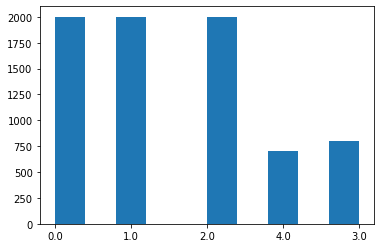

In [ ]:
plt.hist(df['Retinopathy grade'])
plt.show()

In [ ]:
mapping = {0 : [1., 0., 0., 0., 0.] , 1 : [0., 1., 0., 0., 0.], 2 :[0., 0., 1., 0., 0.], 3 : [0., 0., 0., 1., 0.] , 4 : [0., 0., 0., 0., 1.]}

train_label = train_labels['level'].tolist()
for i in range(len(train_labels)):
  train_label[i] = np.array(mapping[train_label[i]])


In [ ]:
train_label


[array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([1., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1.

In [ ]:
colorimage = cv2.imread('/content/imagess/content/image/1000image1222_left.jpg')
norm = np.zeros((800,800))
#colorimage = cv2.normalize(colorimage, norm, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
# Resizing the image for compatibility
colorimage = cv2.resize(colorimage, (100, 100))

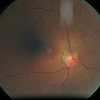

In [ ]:
cv2_imshow(colorimage)

In [ ]:
clahe_model = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))

In [ ]:
colorimage_b = clahe_model.apply(colorimage[:,:,0])
colorimage_g = clahe_model.apply(colorimage[:,:,1])
colorimage_r = clahe_model.apply(colorimage[:,:,2])

In [ ]:
# Next we stack our equalized channels back into a single image
colorimage_clahe = np.stack((colorimage_b,colorimage_g,colorimage_r), axis=2)

The preprocessed image will look like:

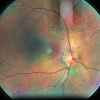

In [ ]:
cv2_imshow(colorimage_clahe)

In [ ]:
import re
def natural_key(string_):
    """See https://blog.codinghorror.com/sorting-for-humans-natural-sort-order/"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]
l = []
PATH2 = "/content/imagess/content/image"
for i in os.listdir(PATH2):
  l.append(i)
l = sorted(l, key=natural_key)

In [ ]:
PATH2 = "/content/imagess/content/image"
training_data = []
for file in l:
  print(file)
  image = cv2.imread(PATH2+"/"+file)
  training_data.append(cv2.resize(image, (100,100)))


Streaming output truncated to the last 5000 lines.
2505image3103_right.jpg
2506image3104_left.jpg
2507image3104_right.jpg
2508image3106_left.jpg
2509image3106_right.jpg
2510image3112_left.jpg
2511image3112_right.jpg
2512image3114_left.jpg
2513image3114_right.jpg
2514image3116_left.jpg
2515image3116_right.jpg
2516image3121_left.jpg
2517image3121_right.jpg
2518image3123_left.jpg
2519image3123_right.jpg
2520image3124_left.jpg
2521image3124_right.jpg
2522image3130_left.jpg
2523image3130_right.jpg
2524image3135_left.jpg
2525image3135_right.jpg
2526image3139_left.jpg
2527image3139_right.jpg
2528image3141_left.jpg
2529image3141_right.jpg
2530image3142_left.jpg
2531image3142_right.jpg
2532image3144_left.jpg
2533image3144_right.jpg
2534image3146_left.jpg
2535image3146_right.jpg
2536image3148_left.jpg
2537image3148_right.jpg
2538image3149_left.jpg
2539image3149_right.jpg
2540image3159_left.jpg
2541image3159_right.jpg
2542image3160_left.jpg
2543image3160_right.jpg
2544image3163_left.jpg
2545image

In [ ]:
print(len(training_data))

7505


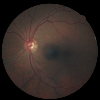

In [ ]:
my_img = Image.fromarray(training_data[10])
cv2_imshow(training_data[10])

We use ImageDataGenerator to add more images to the labels which has low image count.

In [ ]:
train_labels[['level']].value_counts()

level
0.0      2001
1.0      2001
2.0      2001
3.0       801
4.0       701
dtype: int64

In [ ]:
from numpy import expand_dims
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
train_extra = []
label_extra = []
for d in range(len(training_data)):
  data = training_data[d]
  samples = expand_dims(data, 0)
  datagen = ImageDataGenerator(brightness_range=[0.4,2.0],horizontal_flip=True)
  it = datagen.flow(samples, batch_size=1)
  # comparison = an_array == another_array
  # equal_arrays = comparison.all()
  if(list(train_label[d])==[0., 0., 0., 0., 1.]):
    k=3
  elif(list(train_label[d])==[0., 0., 0., 1., 0.]):
    k=3
  else:
    k=0
  for i in range(k):
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    train_extra.append(image)
    label_extra.append(train_label[d])


training_data.extend(train_extra)
train_label.extend(label_extra)

In [ ]:
print(len(train_extra))
print(len(label_extra))
print(len(training_data))
print(len(train_label))

4506
4506
12011
12011


In [ ]:
import gc
gc.collect()
del train_extra
del label_extra

In [ ]:
new_train=[]

In [ ]:

for i in training_data:
  colorimage_b = clahe_model.apply(i[:,:,0])
  colorimage_g = clahe_model.apply(i[:,:,1])
  colorimage_r = clahe_model.apply(i[:,:,2])
  colorimage_clahe = np.stack((colorimage_b,colorimage_g,colorimage_r), axis=2)
  new_train.append(colorimage_clahe/255)

In [ ]:
print(len(new_train))
print(len(train_label))
print(type(train_label))
print(type(new_train))

12011
12011
<class 'list'>
<class 'list'>


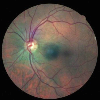

In [ ]:
cv2_imshow(new_train[10]*255)

In [ ]:
#Shuffling the training data to ensure equal distribution of images in each folds
import random
temp = list(zip(training_data, train_label))
random.shuffle(temp)
res1, res2 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
f_training_data, f_train_labels = list(res1), list(res2)

In [ ]:
import gc
gc.collect()
del temp
del res1
del res2

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(f_training_data, f_train_labels, test_size=0.2,random_state=75)
print (len(X_train), len(y_train))

9608 9608


##Base Line Model

In [ ]:
import torchvision.models as models
from keras.models import Sequential
model1 = Sequential()
model1.add(layers.Conv2D(filters = 32, kernel_size = 3, 
                        activation = 'relu', padding = 'same', 
                        input_shape=(100, 100, 3)))
model1.add(layers.MaxPooling2D(pool_size = (2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation = 'relu'))
model1.add(layers.Dense(64, activation = 'relu'))
model1.add(layers.Dense(5, activation='softmax'))


model1.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

cp = EarlyStopping(patience = 10, restore_best_weights=True)

# fitting the model
history1 = model1.fit(np.array(X_train), np.array(y_train),
                    epochs=50, batch_size=16,
                    validation_data = (np.array(X_valid),np.array(y_valid))
                   )

Epoch 1/50
601/601 [==============================] - 8s 11ms/step - loss: 5.5910 - accuracy: 0.3055 - val_loss: 1.6338 - val_accuracy: 0.3587
Epoch 2/50
601/601 [==============================] - 6s 10ms/step - loss: 1.4401 - accuracy: 0.3930 - val_loss: 1.3986 - val_accuracy: 0.4253
Epoch 3/50
601/601 [==============================] - 5s 8ms/step - loss: 1.2568 - accuracy: 0.4721 - val_loss: 1.2961 - val_accuracy: 0.4515
Epoch 4/50
601/601 [==============================] - 5s 8ms/step - loss: 1.0966 - accuracy: 0.5484 - val_loss: 1.2565 - val_accuracy: 0.4898
Epoch 5/50
601/601 [==============================] - 4s 7ms/step - loss: 0.9405 - accuracy: 0.6199 - val_loss: 1.2304 - val_accuracy: 0.5073
Epoch 6/50
601/601 [==============================] - 5s 8ms/step - loss: 0.8068 - accuracy: 0.6859 - val_loss: 1.1625 - val_accuracy: 0.5460
Epoch 7/50
601/601 [==============================] - 5s 8ms/step - loss: 0.6673 - accuracy: 0.7480 - val_loss: 1.3166 - val_accuracy: 0.5381
Epoc

In [ ]:
print('validation data evaluation')
model1.evaluate(np.array(X_valid), np.array(y_valid))

validation data evaluation
76/76 [==============================] - 0s 5ms/step - loss: 4.3832 - accuracy: 0.5714


[4.383235931396484, 0.5713691115379333]

In [ ]:
y_pred = model1.predict(np.array(X_valid))

76/76 [==============================] - 0s 3ms/step


In [ ]:
y_pre = []
for i in y_pred:
  y_pre.append(np.argmax(i))
y_te=[]
for i in y_valid:
  y_te.append(np.argmax(i))

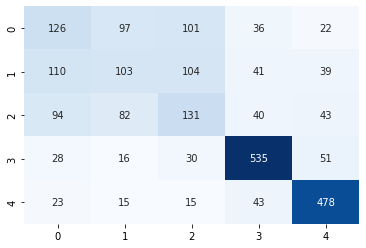

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_te, y_pre), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

##ResNet Model

In [ ]:
#resnet50
from keras.applications import *
model_res = Sequential()
model_res.add(ResNet50(input_shape=(100,100,3),include_top=False,weights=None))
for layer in model_res.layers:
    layer.trainable = False
model_res.add(Flatten())
model_res.add(Dense(16,kernel_initializer='he_uniform'))
model_res.add(BatchNormalization())
model_res.add(Activation('relu'))
model_res.add(Dropout(0.5))
model_res.add(Dense(units= 5, activation='softmax'))

c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
model_res.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_res=model_res.fit(np.array(X_train),np.array(y_train),epochs=20,batch_size=16,validation_data = (np.array(X_valid),np.array(y_valid)))

Epoch 1/20
601/601 [==============================] - 19s 26ms/step - loss: 1.7358 - accuracy: 0.2306 - val_loss: 1.5327 - val_accuracy: 0.3030
Epoch 2/20
601/601 [==============================] - 14s 23ms/step - loss: 1.5827 - accuracy: 0.2675 - val_loss: 1.5771 - val_accuracy: 0.2776
Epoch 3/20
601/601 [==============================] - 14s 23ms/step - loss: 1.5550 - accuracy: 0.2853 - val_loss: 1.5285 - val_accuracy: 0.2938
Epoch 4/20
601/601 [==============================] - 14s 23ms/step - loss: 1.5453 - accuracy: 0.2841 - val_loss: 1.6352 - val_accuracy: 0.2260
Epoch 5/20
601/601 [==============================] - 14s 23ms/step - loss: 1.5415 - accuracy: 0.2881 - val_loss: 1.5270 - val_accuracy: 0.3159
Epoch 6/20
601/601 [==============================] - 14s 23ms/step - loss: 1.5309 - accuracy: 0.2942 - val_loss: 1.6455 - val_accuracy: 0.2801
Epoch 7/20
601/601 [==============================] - 14s 24ms/step - loss: 1.5235 - accuracy: 0.3015 - val_loss: 1.4940 - val_accuracy:

In [ ]:
print('validation data evaluation')
model_res.evaluate(np.array(X_valid), np.array(y_valid))

validation data evaluation
76/76 [==============================] - 3s 28ms/step - loss: 1.4073 - accuracy: 0.3616


[1.407325267791748, 0.36163130402565]

In [ ]:
y_pred = model_res.predict(np.array(X_valid))

76/76 [==============================] - 3s 25ms/step


In [ ]:
y_pre = []
for i in y_pred:
  y_pre.append(np.argmax(i))
y_te=[]
for i in y_valid:
  y_te.append(np.argmax(i))

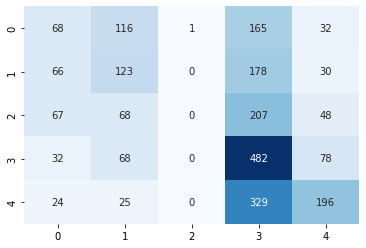

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_te, y_pre), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

##Efficent NetB3

In [ ]:
#EfficientNetB3

img_shape=(100,100, 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(5, activation='softmax')(x)
model_ef1=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model_ef1.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs=20
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop]

In [ ]:
history_ef1=model_ef1.fit(np.array(X_train),np.array(y_train),  epochs=epochs, batch_size=16, verbose=1, callbacks=callbacks,  validation_data=(np.array(X_valid),np.array(y_valid)),
               validation_steps=None,  shuffle=False,  initial_epoch=0)


Epoch 1/20
601/601 [==============================] - 60s 100ms/step - loss: 0.8710 - accuracy: 0.6848 - val_loss: 1.0787 - val_accuracy: 0.6105 - lr: 0.0010
Epoch 2/20
601/601 [==============================] - 58s 97ms/step - loss: 0.8177 - accuracy: 0.7137 - val_loss: 1.0513 - val_accuracy: 0.6080 - lr: 0.0010
Epoch 3/20
601/601 [==============================] - 58s 97ms/step - loss: 0.7542 - accuracy: 0.7369 - val_loss: 1.0020 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 4/20
601/601 [==============================] - 60s 100ms/step - loss: 0.7011 - accuracy: 0.7560 - val_loss: 1.0175 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 5/20
601/601 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7712
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
601/601 [==============================] - 58s 96ms/step - loss: 0.6598 - accuracy: 0.7712 - val_loss: 1.0345 - val_accuracy: 0.6563 - lr: 0.0010
Epoch 6/20
601/601 [==============================] 

In [ ]:
y_pred = model_ef1.predict(np.array(X_valid))

76/76 [==============================] - 41s 31ms/step


In [ ]:
y_pre = []
for i in y_pred:
  y_pre.append(np.argmax(i))
y_te=[]
for i in y_valid:
  y_te.append(np.argmax(i))

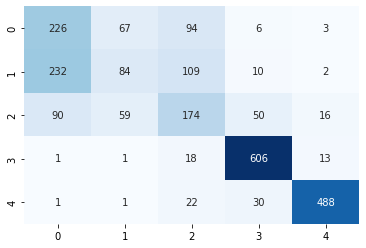

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_te, y_pre), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

##Adding Attention 


In [ ]:
#attention model

from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input((100,100,3))
base_pretrained_model = PTModel(input_shape = (100,100,3), include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth= base_pretrained_model.layers[0].compute_output_shape(input_shape = (100,100,3))


pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, 2048))
up_c2 = Conv2D(2048, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(5, activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['accuracy','mse'])
retina_model.summary()

retina_model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_valid), np.array(y_valid)), epochs=20, batch_size=16)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 1, 1, 2048)   21802784    ['input_18[0][0]']               
                                                                                                  
 batch_normalization_569 (Batch  (None, 1, 1, 2048)  8192        ['inception_v3[0][0]']           
 Normalization)                                                                                   
                                                                                            

##Inception model

In [ ]:
#inception model

from keras.layers import Input
input_img = Input(shape = (100, 100, 3))

In [ ]:
from keras.layers import Conv2D, MaxPooling2D
tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)
tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)
tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)

In [ ]:
import keras
output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

In [ ]:
from keras.layers import Flatten, Dense
output = Flatten()(output)
out    = Dense(5, activation='softmax')(output)

In [ ]:
from keras.models import Model
model = Model(inputs = input_img, outputs = out)
# print model.summary()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  256         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 100, 100, 64  256         ['input_1[0][0]']                
                                )                                                             

In [ ]:
from keras.optimizers import SGD
lrate = 0.01
decay = lrate/20
sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_valid), np.array(y_valid)), epochs=20, batch_size=16)


Epoch 1/20
601/601 [==============================] - 37s 47ms/step - loss: 1107459196321792.0000 - accuracy: 0.3024 - val_loss: 1.4721 - val_accuracy: 0.3487
Epoch 2/20
601/601 [==============================] - 28s 46ms/step - loss: 1.3928 - accuracy: 0.3961 - val_loss: 1.4442 - val_accuracy: 0.3604
Epoch 3/20
601/601 [==============================] - 28s 47ms/step - loss: 1.2503 - accuracy: 0.4754 - val_loss: 1.4741 - val_accuracy: 0.3795
Epoch 4/20
601/601 [==============================] - 28s 46ms/step - loss: 1.1399 - accuracy: 0.5279 - val_loss: 1.5072 - val_accuracy: 0.4070
Epoch 5/20
601/601 [==============================] - 28s 47ms/step - loss: 1.0357 - accuracy: 0.5734 - val_loss: 1.5887 - val_accuracy: 0.4087
Epoch 6/20
601/601 [==============================] - 28s 47ms/step - loss: 0.9524 - accuracy: 0.6125 - val_loss: 1.5597 - val_accuracy: 0.4124
Epoch 7/20
601/601 [==============================] - 28s 46ms/step - loss: 0.8795 - accuracy: 0.6418 - val_loss: 1.7373 

##VGG16 model

In [ ]:
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization

base_model = VGG16(weights='imagenet',include_top=False, pooling=None, input_shape=(100,100,3))

x = base_model.output
x = Flatten(name = "flatten")(x)
x = Dense(384, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(32, activation = "relu")(x)



output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
# Train top layer
for layer in base_model.layers:
    layer.trainable = False

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_valid), np.array(y_valid)), epochs=50, batch_size=16)

Epoch 1/50
601/601 [==============================] - 20s 29ms/step - loss: 1.5117 - accuracy: 0.3400 - val_loss: 1.3315 - val_accuracy: 0.4132
Epoch 2/50
601/601 [==============================] - 18s 31ms/step - loss: 1.3551 - accuracy: 0.4017 - val_loss: 1.2485 - val_accuracy: 0.4540
Epoch 3/50
601/601 [==============================] - 17s 28ms/step - loss: 1.2837 - accuracy: 0.4414 - val_loss: 1.2354 - val_accuracy: 0.4569
Epoch 4/50
601/601 [==============================] - 17s 28ms/step - loss: 1.2437 - accuracy: 0.4624 - val_loss: 1.2097 - val_accuracy: 0.4752
Epoch 5/50
601/601 [==============================] - 17s 28ms/step - loss: 1.2062 - accuracy: 0.4700 - val_loss: 1.1627 - val_accuracy: 0.5027
Epoch 6/50
601/601 [==============================] - 17s 28ms/step - loss: 1.1792 - accuracy: 0.4786 - val_loss: 1.1905 - val_accuracy: 0.4915
Epoch 7/50
601/601 [==============================] - 17s 28ms/step - loss: 1.1496 - accuracy: 0.4942 - val_loss: 1.1458 - val_accuracy:

In [ ]:
print('validation data evaluation')
model.evaluate(np.array(X_valid), np.array(y_valid))

validation data evaluation
76/76 [==============================] - 4s 38ms/step - loss: 1.1520 - accuracy: 0.5814


[1.1520330905914307, 0.5813566446304321]

In [ ]:
y_pred = model.predict(np.array(X_valid))

76/76 [==============================] - 3s 38ms/step


In [ ]:
y_pre = []
for i in y_pred:
  y_pre.append(np.argmax(i))
y_te=[]
for i in y_valid:
  y_te.append(np.argmax(i))

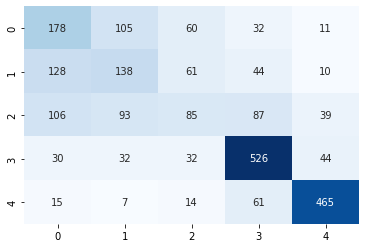

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_te, y_pre), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

##DenseNet Model

In [ ]:
base_model = DenseNet121(weights='imagenet',include_top=False, pooling='max', input_shape=(100,100,3))

x = base_model.output
x = Dropout(0.4)(x)

output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
# Train top layer
for layer in base_model.layers[:3]:
    layer.trainable = False

print(model.summary())

29084464/29084464 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalizati

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_valid), np.array(y_valid)), epochs=50, batch_size=16)

Epoch 1/50
601/601 [==============================] - 56s 72ms/step - loss: 2.2389 - accuracy: 0.2442 - val_loss: 6.5828 - val_accuracy: 0.2077
Epoch 2/50
601/601 [==============================] - 39s 64ms/step - loss: 2.0412 - accuracy: 0.2518 - val_loss: 5.6430 - val_accuracy: 0.2905
Epoch 3/50
601/601 [==============================] - 40s 66ms/step - loss: 1.9309 - accuracy: 0.2554 - val_loss: 37.1559 - val_accuracy: 0.2276
Epoch 4/50
601/601 [==============================] - 40s 66ms/step - loss: 1.8241 - accuracy: 0.2732 - val_loss: 1.4936 - val_accuracy: 0.3271
Epoch 5/50
601/601 [==============================] - 38s 64ms/step - loss: 1.7047 - accuracy: 0.3036 - val_loss: 2.5487 - val_accuracy: 0.3454
Epoch 6/50
601/601 [==============================] - 38s 64ms/step - loss: 1.6730 - accuracy: 0.3155 - val_loss: 13.7487 - val_accuracy: 0.2801
Epoch 7/50
601/601 [==============================] - 38s 63ms/step - loss: 1.7330 - accuracy: 0.2788 - val_loss: 2.3251 - val_accurac

In [ ]:
print('validation data evaluation')
model.evaluate(np.array(X_valid), np.array(y_valid))

validation data evaluation
76/76 [==============================] - 4s 39ms/step - loss: 3.5031 - accuracy: 0.5035


[3.5031490325927734, 0.5035372376441956]

In [ ]:
y_pred = model.predict(np.array(X_valid))

76/76 [==============================] - 3s 22ms/step


In [ ]:
y_pre = []
for i in y_pred:
  y_pre.append(np.argmax(i))
y_te=[]
for i in y_valid:
  y_te.append(np.argmax(i))

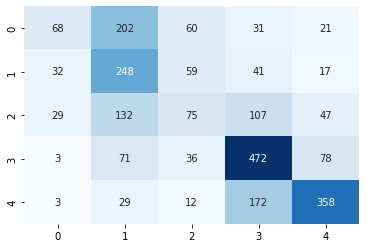

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_te, y_pre), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

#FINAL MODEL

From the above results we can conclude that the EfficientNetB3 model with a validation accuracy of 68.08% works best for the current challenge.

##Efficent NetB3

In [ ]:
#EfficientNetB3

img_shape=(100,100, 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(5, activation='softmax')(x)
model_ef1=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model_ef1.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 3s 0us/step


In [ ]:
epochs=20
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop]

In [ ]:
history_ef1=model_ef1.fit(np.array(X_train),np.array(y_train),  epochs=epochs, batch_size=16, verbose=1, callbacks=callbacks,  validation_data=(np.array(X_valid),np.array(y_valid)),
               validation_steps=None,  shuffle=False,  initial_epoch=0)


Epoch 1/20
601/601 [==============================] - 87s 107ms/step - loss: 14.4115 - accuracy: 0.3094 - val_loss: 6.9339 - val_accuracy: 0.3683 - lr: 0.0010
Epoch 2/20
601/601 [==============================] - 61s 102ms/step - loss: 4.2606 - accuracy: 0.3802 - val_loss: 2.5609 - val_accuracy: 0.4565 - lr: 0.0010
Epoch 3/20
601/601 [==============================] - 59s 98ms/step - loss: 2.0268 - accuracy: 0.4547 - val_loss: 1.6029 - val_accuracy: 0.5006 - lr: 0.0010
Epoch 4/20
601/601 [==============================] - 59s 97ms/step - loss: 1.4407 - accuracy: 0.5165 - val_loss: 1.3174 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 5/20
601/601 [==============================] - 59s 98ms/step - loss: 1.2102 - accuracy: 0.5593 - val_loss: 1.1533 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 6/20
601/601 [==============================] - 59s 97ms/step - loss: 1.0770 - accuracy: 0.5940 - val_loss: 1.1702 - val_accuracy: 0.5597 - lr: 0.0010
Epoch 7/20
601/601 [==============================] - 5

In [ ]:
y_pred = model_ef1.predict(np.array(X_valid))

76/76 [==============================] - 4s 46ms/step


In [ ]:
y_pre = []
for i in y_pred:
  y_pre.append(np.argmax(i))
y_te=[]
for i in y_valid:
  y_te.append(np.argmax(i))

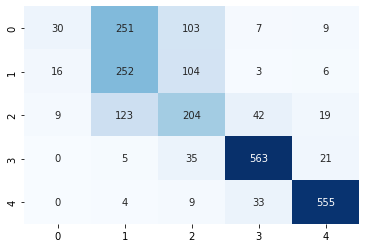

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_te, y_pre), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

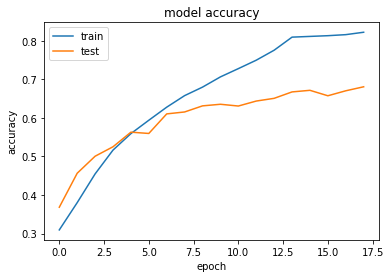

In [ ]:
# summarize history for accuracy
plt.plot(history_ef1.history['accuracy'])
plt.plot(history_ef1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


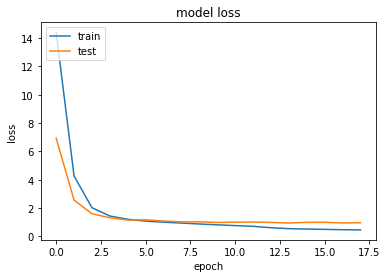

In [ ]:
# summarize history for loss
plt.plot(history_ef1.history['loss'])
plt.plot(history_ef1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support  = score(y_te, y_pre)
index=['Level 0','Level 1','Level 2','Level 3','Level 4']
df_from_arr1 = pd.DataFrame(data=[index,precision, recall,fscore ]).T
df_from_arr1.columns = ['Levels','precision', 'recall', 'fscore' ]
print(df_from_arr1)

    Levels precision    recall    fscore
0  Level 0  0.545455     0.075  0.131868
1  Level 1   0.39685  0.661417  0.496063
2  Level 2  0.448352  0.513854  0.478873
3  Level 3  0.868827  0.902244   0.88522
4  Level 4  0.909836  0.923461  0.916598
